# Fragment Mech Simulation with Reattachment

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rmgpy.chemkin import *
from rmgpy.species import Species

In [3]:
from afm.simulator_2mo import OdeSimulator
import afm.utils_1_sided
import afm.simulator_2mo

/home/yentingw/RMG/RMG-Py/rmgpy/tools/plot.py:31: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/pyth

## 1. specify condition and simulate

In [4]:
temperature = 673.15 # K
pressure = 350*3 # bar

initial_mol_fraction = {
    "ArCC(C)R":1.0,
    "RCCCCR":1.0,
    "RCC":1.0
}
hr = 14
termination_time = 3600*hr # hrs

In [5]:
model = 'one-sided'
working_dir = os.path.join('../', 'data', '2mobenzene', model)
chemkin_path = os.path.join(working_dir, 'chem_annotated.inp')
species_dict_path = os.path.join(working_dir, 'species_dictionary.txt')
smiles_dict_path = os.path.join(working_dir, 'fragment_smiles.txt')

In [6]:
ode_simulator = OdeSimulator(chemkin_path,
                             species_dict_path,
                             smiles_dict_path,
                             temperature,
                             pressure)

In [7]:
alldata = ode_simulator.simulate(initial_mol_fraction, termination_time)

In [8]:
results_path = os.path.join(working_dir, 'results')
if not os.path.exists(results_path):
    os.mkdir(results_path)

## 2. reactant conversion

In [9]:
# prepare moles data
time, dataList, _ = alldata[0]
TData = dataList[0]
PData = dataList[1]
VData = dataList[2]
total_moles = PData.data*VData.data/8.314/TData.data

moles_dict = {}
for data in dataList[3:]:
    spe_label = data.label
    moles_dict[spe_label] = max(data.data[-1]*total_moles[-1],0)

In [10]:
moles_dict

{'Ar': 0.0,
 'Ar*': 3.7151826214527513e-12,
 'ArAr': 87.98537273963133,
 'ArC': 966.66667237527258,
 'ArC(C*)C(C)R': 0.0,
 'ArC(C*CCR)C(C)R': 0.0,
 'ArC(CC*CR)C(C)R': 2.8321915865723084e-07,
 'ArC(CCC*R)C(C)R': 0.0,
 'ArC(CCCCR)C(C)R': 0.0,
 'ArC(CCCR)C(C)R': 0.0,
 'ArC(CCCR)C(C*)R': 0.0,
 'ArC(CCCR)C*(C)R': 0.0,
 'ArC(CCCR)__CR': 0.0,
 'ArC(C__C)C(C)R': 0.0,
 'ArC(__C)C(C)R': 0.0,
 'ArC*': 3.7790490861129846e-06,
 'ArC*(CCCCR)C(C)R': 0.0,
 'ArC*(CCCR)C(C)R': 0.0,
 'ArC*C': 0.0,
 'ArC*C(C)R': 3.6761977319199354e-05,
 'ArCC': 0.0,
 'ArCC(C)R': 5105.8125751726866,
 'ArCC(C*)R': 4.7807428117421798e-08,
 'ArCC*': 0.0,
 'ArCC*(C)R': 8.6874306014693255e-07,
 'ArCC*R': 1.0409283822781981e-05,
 'ArCCC': 0.0,
 'ArCCC*': 0.0,
 'ArCC__C': 0.0,
 'ArC__C': 0.0,
 'ArC__C(C)R': 0.0,
 'ArC__CCCR': 0.0,
 'ArC__CR': 5.381431681518408,
 'C*': 8.5438501609652172e-07,
 'C__C': 9.7429821896608475e-05,
 'H*': 1.2703230800610122e-19,
 'H2': 8.838103354025983e-06,
 'RC': 535.43305780817627,
 'RC(C)C': 1.113202

In [11]:
ArCC_C_CR_mf = dataList[3].data
print dataList[3].label
print dataList[3].data
ArCC_C_CR_moles = ArCC_C_CR_mf*total_moles # total_moles is an array in the form of tuple and list in the tuple
ArCC_C_CR_conv = (ArCC_C_CR_moles[0]-ArCC_C_CR_moles)/ArCC_C_CR_moles[0]

ArCC(C)R
[ 0.33333333  0.33333333  0.33333333 ...,  0.25357889  0.25332287
  0.25306813]


In [12]:
ArCC_C_CR_conv

array([  0.00000000e+00,   4.95916295e-14,   1.46302578e-13, ...,
         1.82334418e-01,   1.82953896e-01,   1.83570489e-01])

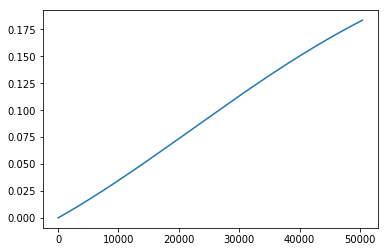

In [13]:
plt.plot(time.data, ArCC_C_CR_conv)
numpy.savetxt(os.path.join(results_path, 'reactant_conv.csv'), (time.data, ArCC_C_CR_conv))

## 3. molecular weight distribution

In [14]:
from afm.simulator_2mo import categorize_fragments

In [15]:
r_moles, remain_moles, rr_list = categorize_fragments(moles_dict)
print rr_list

['RCCCCR', 'RCC__CCR']


In [16]:
r_moles

[('RCCCCR', 11436.630791315127),
 ('ArCC(C)R', 5105.8125751726866),
 ('RCCC', 0.012716126898225669),
 ('RC(C)__C', 5.3501881225103078),
 ('RC__C', 867.91889216849177),
 ('RCC', 6347.2686003396002),
 ('RC', 535.43305780817627),
 ('ArC__CR', 5.381431681518408),
 ('RC(C)C', 1.1132027555465077e-06),
 ('RCC__CCR', 0.095458536851068476),
 ('RCC__C', 535.45131869222371)]

In [17]:
remain_moles

[('ArAr', 87.98537273963133),
 ('ArC__C(C)R', 0.0),
 ('ArC(__C)C(C)R', 0.0),
 ('ArC(C*CCR)C(C)R', 0.0),
 ('C__C', 9.7429821896608475e-05),
 ('ArC(CCCR)C(C)R', 0.0),
 ('ArC__CCCR', 0.0),
 ('C*', 8.5438501609652172e-07),
 ('ArC(CCCR)__CR', 0.0),
 ('RC(C*)C', 4.2995957422036093e-05),
 ('RCCC*', 3.200912128854544e-13),
 ('RCC*CCR', 3.451518942171787e-07),
 ('ArC*(CCCR)C(C)R', 0.0),
 ('ArC(C__C)C(C)R', 0.0),
 ('RCCCCCC*', 1.4742146721391386e-18),
 ('ArC__C', 0.0),
 ('ArC(CC*CR)C(C)R', 2.8321915865723084e-07),
 ('ArC*', 3.7790490861129846e-06),
 ('Ar*', 3.7151826214527513e-12),
 ('ArCCC', 0.0),
 ('RC*C__C', 3.6862045137869334e-05),
 ('ArC*(CCCCR)C(C)R', 0.0),
 ('ArC(CCCCR)C(C)R', 0.0),
 ('ArCC*', 0.0),
 ('RC*CCCR', 3.48244264088315e-07),
 ('ArC*C', 0.0),
 ('ArCC', 0.0),
 ('ArCC*R', 1.0409283822781981e-05),
 ('ArCC*(C)R', 8.6874306014693255e-07),
 ('ArC', 966.66667237527258),
 ('RC*C', 9.0871416069443466e-07),
 ('ArC(CCCR)C(C*)R', 0.0),
 ('RCCCCC*', 1.5665366114886725e-18),
 ('ArCC__C', 0.0),

In [36]:
fragmental_weight_distri = ode_simulator.get_molecular_weight_distribution(alldata)

AttributeError: 'Fragment' object has no attribute 'get_fragmental_weight'

In [16]:
fragmental_weight_distri

[(0.23635140201076865, 87.98537273963133),
 (0.11716776096727699, 0.0),
 (0.13119434111285955, 0.0),
 (0.15924750140402466, 0.0),
 (0.028053160291165113, 9.7429821896608475e-05),
 (0.160255441442132, 0.0),
 (0.13119434111285955, 0.0),
 (0.015034520183689892, 8.5438501609652172e-07),
 (0.14421298122033477, 0.0),
 (0.04207974043674767, 4.2995957422036093e-05),
 (0.04207974043674767, 3.200912128854544e-13),
 (0.05509838054422289, 3.451518942171787e-07),
 (0.15924750140402466, 0.0),
 (0.1452209212584421, 0.0),
 (0.08415948087349534, 1.4742146721391386e-18),
 (0.10414912085980177, 0.0),
 (0.15924750140402466, 2.8321915865723084e-07),
 (0.09113048075232655, 3.7790490861129846e-06),
 (0.07710390060674399, 3.7151826214527513e-12),
 (0.120191581081599, 0.0),
 (0.040063860360533, 3.6862045137869334e-05),
 (0.17327408154960722, 0.0),
 (0.17428202158771455, 0.0),
 (0.1051570608979091, 0.0),
 (0.05509838054422289, 3.48244264088315e-07),
 (0.1051570608979091, 0.0),
 (0.10616500093601644, 0.0),
 (0.1

In [25]:
matches = ode_simulator.reattach_fragments(r_moles, rr_list, grind_size = 1, shuffle_seed = 0)
matches

[((('RCC', 'RCCCCR', 'RCC'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('RC', 'RCCCCR', 'RC'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('ArCC(C)R', 'RCC'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('ArCC(C)R', 'RCC'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('ArCC(C)R', 'RCCCCR', 'ArCC(C)R'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('ArCC(C)R', 'RCC'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('ArCC(C)R', 'RCC'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('RCC', 'RCCCCR', 'RCC'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('RCC', 'RCCCCR', 'RCC'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('RCC', 'ArCC(C)R'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('RCC', 'ArCC(C)R'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('ArCC(C)R', 'RCCCCR', 'ArCC(C)R'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('ArCC(C)R', 'ArCC(C)R'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('ArCC(C)R', 'ArCC(C)R'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('ArCC(C)R', 'RCC'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('ArCC(C)R', 'RCC'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('RCC', 'RCCCCR', 'RCC'), ('RCCCCR', 'RCCCCR')), 0.5),
 ((('RCC__C', 'RCCCCR', 'RCC__C'), (

In [18]:
mws = [tup[0]*1000 for tup in fragmental_weight_distri]
moles = [tup[1] for tup in fragmental_weight_distri]

molefracs = moles/sum(moles)

In [19]:
numpy.savetxt(os.path.join(results_path, 'mwd_{0}hr.csv'.format(hr)), (mws, molefracs))